In [1]:
import matplotlib.pyplot as plt
import numpy as np

# No Metadynamics

In [3]:
%cd 1-aladi-vanilla

/home/francesco/Scrivania/PDF_LEZIONI_2021-22/MOLECULAR_SIMULATION/P6/metad-course-main/1-aladi-vanilla


The *.tpr* file contains all the velocities, the structure and the parameters of the simulation (cutoff, pressure and temperature coupling...). With -nsteps you rewrite the number of steps.

The used force field is f99.

Minimization with gromacs in plumed
* nsteps = number of steps of the minimization

In [9]:
! gmx_mpi mdrun -s topol.tpr -v -nsteps 5000000

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

<img src="images/f1.png" width="600">

From above:
1. Final conformation of the system with positions and velocities
2. 
3. Potential energy
4. log of all possible parameters during siulations
5. checkpoint: you can restart from this point a new simulation. Coordinates and velocities are saved with very high precision
6. 
7. compressed trajectory, maybe for analysis, not for restart

What we want to do now is to create a CV that gives a feels about the main movements of our molecule. For this reson we choose the torsion angles $\phi$ and $\psi$

<img src="images/f2.png" width="300">

Create a file called  `plumed.dat` in which there are the plumed commands to compute the chosen collective variables.
```
phi: TORSION ATOMS=5,7,9,15
psi: TORSION ATOMS=7,9,15,17
PRINT ARG=phi,psi FILE=COLVAR STRIDE=1
```

In [4]:
! plumed driver --plumed plumed.dat --mf_xtc traj_comp.xtc


DRIVER: Found molfile format trajectory xtc with name traj_comp.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/francesco/anaconda3/envs/plumed_MTD/lib/plumed
PLUMED: For installed feature, see /home/francesco/anaconda3/envs/plumed_MTD/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditions
PLUMED: Action TORSION
PLUMED:   with label psi
PLUMED:   between atoms 7 9 15 17
PLUMED:   using periodic boundary conditions
PLUMED: Action PRINT
PLUME

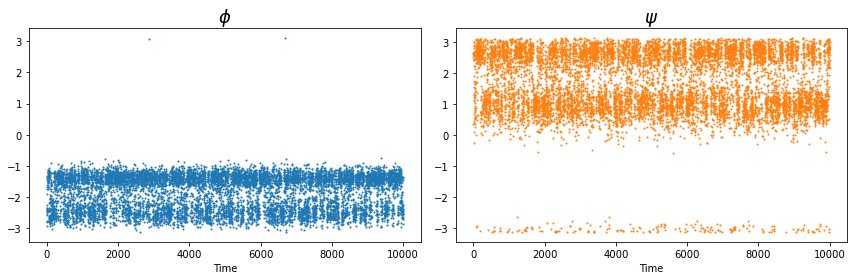

In [13]:
colvar=np.loadtxt("COLVAR", skiprows=5)
_, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(colvar[:,0], colvar[:,1], ".", markersize=2)
ax[1].plot(colvar[:,0], colvar[:,2], ".", markersize=2, color="C1")
ax[0].set_title(r"$\phi$", fontweight="bold", fontsize=18)
ax[1].set_title(r"$\psi$", fontweight="bold", fontsize=18)
[axi.set_xlabel("Time") for axi in ax]
plt.tight_layout()
plt.show()

# Metadynamics

In [11]:
%cd /home/francesco/Scrivania/PDF_LEZIONI_2021-22/MOLECULAR_SIMULATION/P6/metad-course-main/2-aladi-metad

/home/francesco/Scrivania/PDF_LEZIONI_2021-22/MOLECULAR_SIMULATION/P6/metad-course-main/2-aladi-metad


Create a file called  `plumed.dat` in which there are the plumed commands to compute the chosen collective variables.
```
phi: TORSION ATOMS=5,7,9,15
psi: TORSION ATOMS=7,9,15,17

metad: METAD ...
ARG=phi
PACE=500 HEIGHT=1.2 BIASFACTOR=8
# Choose sigma based on fluctuations in unbiased run (1/2 or 1/3)
SIGMA=0.5
FILE=HILLS GRID_MIN=-pi GRID_MAX=pi
...
PRINT ARG=phi,psi,metad.bias FILE=COLVAR STRIDE=100

```

Paramters for metadynamics syntax:
* **PACE**: how often we deposit energy in our system
* **HEIGHT**: the height of the deposited gaussians
* **BIASFACTOR**: related to the tempered metadynamics. Tells how much bias is used as the simulation progresses, i.e. how to scale the height of the gaussian in relation to the amount of energy deposited in that region (8 is quite high value, which means relevant bias). If you don't specify it it runs a standard metadynamics with constant height. In the second formula below it corresponds to $\Delta T$, which has the role of a temperature.
* **SIGMA**: gives a measure of the width of the deposited gaussians. It should be proportional to the fluctuations around the minimum in the no mtd run. You can undershoot $\sigma$, and the simulaiton will basically never converge bacause you add too tiny deposits, or overshoot it, so you still never converge because you will continously jump between different minima.

<img src="images/f3.png" width="400">

In the HILL file we record where and which height were the deposited gaussians.

GRID_MIN and GRID_MAX gives the boundaries for the discretization of the data collected in the HILLS file so to create an histogram. The binning is automatically created by Plumed.

PRINT tells what to print in the COLVAR file. STRIDE is how often to print the data, it's quite high but still 1/5 of the number of steps between to mtd deposits.


In [56]:
! gmx_mpi mdrun -s topol.tpr -v -nsteps 5000000 -plumed plumed.dat

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

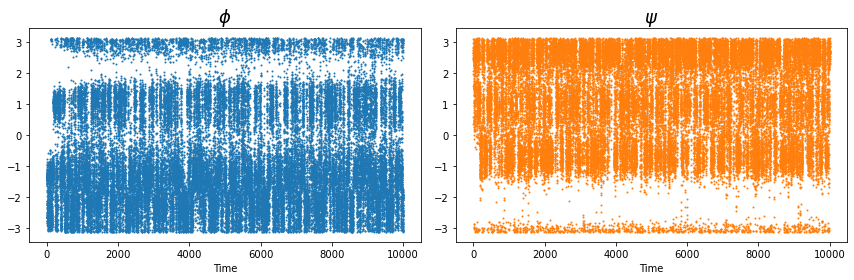

In [60]:
colvar_met=np.loadtxt("COLVAR", skiprows=5)
_, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(colvar_met[:,0], colvar_met[:,1], ".", markersize=2)
ax[1].plot(colvar_met[:,0], colvar_met[:,2], ".", markersize=2, color="C1")
ax[0].set_title(r"$\phi$", fontweight="bold", fontsize=18)
ax[1].set_title(r"$\psi$", fontweight="bold", fontsize=18)
[axi.set_xlabel("Time") for axi in ax]
plt.tight_layout()
plt.show()

Notice that in the first timesteps there was a gap around 2 for the $\phi$ angle, and then progressively it gets filled but not completely because we are running a tempered mtd. The same around 0 (even better, works very well with this kind of mtd).

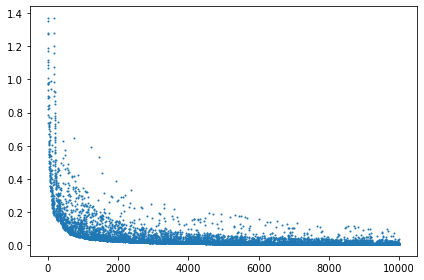

In [61]:
hills = np.loadtxt("HILLS", skiprows=5)
plt.plot(hills[:,0], hills[:,3], ".", markersize=2)
plt.tight_layout()
plt.show()

**Some estimates of convergence**

The command below simply takes the deposited gaussians and sum them up to reconstruct the energy surface.

In [31]:
! plumed sum_hills --hills HILLS

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/francesco/anaconda3/envs/plumed_MTD/lib/plumed
PLUMED: For installed feature, see /home/francesco/anaconda3/envs/plumed_MTD/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finis

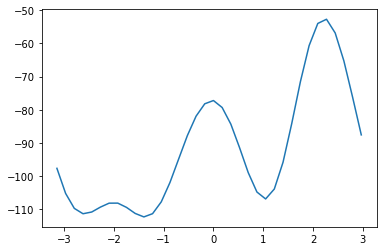

In [62]:
fes = np.loadtxt("fes.dat")
plt.plot(fes[:,0], fes[:,1])

To create the one fes file every *stride* steps. *mintozero* sets the minimum of the potential energy to 0, so to make easier the comparision between the different curves.

In [38]:
! plumed sum_hills --hills HILLS --stride 100 --mintozero

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/francesco/anaconda3/envs/plumed_MTD/lib/plumed
PLUMED: For installed feature, see /home/francesco/anaconda3/envs/plumed_MTD/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finis

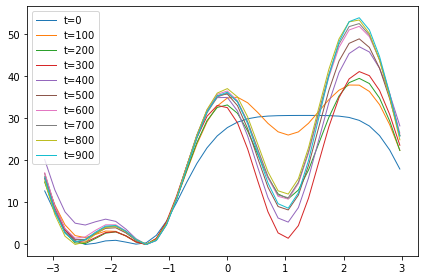

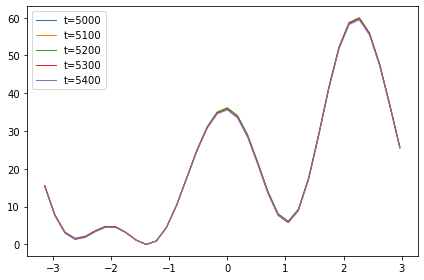

In [66]:
for i in range(0,10):
    fes_i = np.loadtxt(f"fes/fes_{i}.dat")
    plt.plot(fes_i[:,0], fes_i[:,1], lw=1, label="t="+str(100*i))
plt.legend()
plt.tight_layout()
plt.show()

for i in range(50,55):
    fes_i = np.loadtxt(f"fes/fes_{i}.dat")
    plt.plot(fes_i[:,0], fes_i[:,1], lw=1, label="t="+str(100*i))
plt.legend()
plt.tight_layout()
plt.show()

To estimate the convergence in this case we see if the energy profile converge.

A better procedure is to do a cluster analysis over the system. You take the while trajectory, generate clusters with any cluster algorithms (RMS) and if you then divide the thing in 2 groups (time intervals) and the cluster population mathces then you converged.

### Unbiasing

Create a file called  `plumed.dat` in which there are the plumed commands to compute the chosen collective variables. This time the PACE value is very high (a sort of infinity) so that there won't be any deposit in the simulation.

With this procedure we want to extract the bias assigned to the different variables.
```
phi: TORSION ATOMS=5,7,9,15
psi: TORSION ATOMS=7,9,15,17
metad: METAD ...
ARG=phi
PACE=10000000 HEIGHT=0.0 BIASFACTOR=8
SIGMA=0.5 # Use your value here!
FILE=HILLS GRID_MIN=-pi GRID_MAX=pi
RESTART=YES
...
PRINT ARG=phi,psi,metad.bias FILE=COLVAR_RW STRIDE=1

```
In this case we have to specify $k_B T$ becasue Plumed cannot infer it automatically like Gromacs.


In [57]:
! plumed driver --plumed plumed_rw.dat --mf_xtc traj_comp.xtc --kt 2.494339


DRIVER: Found molfile format trajectory xtc with name traj_comp.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/francesco/anaconda3/envs/plumed_MTD/lib/plumed
PLUMED: For installed feature, see /home/francesco/anaconda3/envs/plumed_MTD/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: plumed_rw.dat
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditions
PLUMED: Action TORSION
PLUMED:   with label psi
PLUMED:   between atoms 7 9 15 17
PLUMED:   using periodic boundary conditions
PLUMED: Action METAD
PL

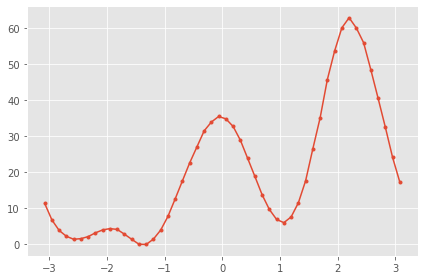

In [12]:
#creates the weights from the bias values
bias = np.loadtxt("COLVAR_RW")[:, -1]
weights = np.exp(bias / 2.494339) #kBT
weights /= weights.sum()

#generates the 1D free energy surface
phi, psi = np.loadtxt("COLVAR_RW")[:, [1, 2]].T
hist, edges = np.histogram(phi, bins=50, range=(-np.pi, np.pi),
density=True, weights=weights) #critical part id the weights
x = 0.5 * (edges[:-1] + edges[1:])
F = -2.494339 * np.log(hist)
F -= F.min()
with plt.style.context("ggplot"):
    plt.plot(x, F, ".-") 
plt.tight_layout()
plt.show()

The final result is the "real" profile of the energy. (We eliminated the bias)

# 2D Metadynamics

In [2]:
%cd /home/francesco/Scrivania/PDF_LEZIONI_2021-22/MOLECULAR_SIMULATION/P6/metad-course-main/3-aladi-metad2d

/home/francesco/Scrivania/PDF_LEZIONI_2021-22/MOLECULAR_SIMULATION/P6/metad-course-main/3-aladi-metad2d


Create a file called  `plumed.dat` in which there are the plumed commands to compute the chosen collective variables.
```
phi: TORSION ATOMS=5,7,9,15
psi: TORSION ATOMS=7,9,15,17
metad: METAD ...
ARG=phi,psi
PACE=500 HEIGHT=1.2 BIASFACTOR=14
# Choose sigma based on fluctuations in unbiased run (1/2 or 1/3)
SIGMA=0.5,0.5
FILE=HILLS GRID_MIN=-pi,-pi GRID_MAX=pi,pi
...
PRINT ARG=phi,psi,metad.bias FILE=COLVAR STRIDE=100

```

In [24]:
! gmx_mpi mdrun -s topol.tpr -v -nsteps 1000000 -plumed plumed.dat

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

Create a file called  `plumed_rw.dat` in which there are the plumed commands to compute the chosen collective variables.
```
phi: TORSION ATOMS=5,7,9,15
psi: TORSION ATOMS=7,9,15,17
metad: METAD ...
ARG=phi,psi
PACE=10000000 HEIGHT=0.0 BIASFACTOR=14
# Choose previous values
SIGMA=0.5,0.5
FILE=HILLS GRID_MIN=-pi,-pi GRID_MAX=pi,pi
RESTART=YES
...
PRINT ARG=phi,psi,metad.bias FILE=COLVAR STRIDE=100

```

The BIASFACTOR is higher because as you increase the dimensions, you will need more energy to cross barriers (rule of thumb $10\sqrt{ncv}$ with $ncv$ number of collective variables)

In [25]:
! plumed driver --plumed plumed_rw.dat --mf_xtc traj_comp.xtc --kt 2.494339


DRIVER: Found molfile format trajectory xtc with name traj_comp.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/francesco/anaconda3/envs/plumed_MTD/lib/plumed
PLUMED: For installed feature, see /home/francesco/anaconda3/envs/plumed_MTD/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: plumed_rw.dat
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditions
PLUMED: Action TORSION
PLUMED:   with label psi
PLUMED:   between atoms 7 9 15 17
PLUMED:   using periodic boundary conditions
PLUMED: Action METAD
PL

/tmp/ipykernel_6562/3628188037.py:9: RuntimeWarning: divide by zero encountered in log
  F = -2.494339 * np.log(hist)


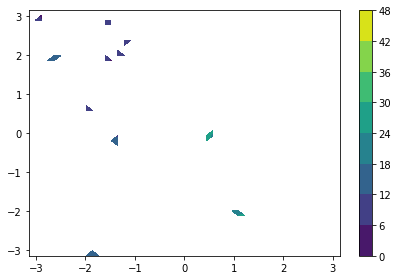

In [26]:
#creates the weights_rw from the bias_rw values
bias_rw = np.loadtxt("COLVAR_RW")[:, -1]
weights_rw = np.exp(bias_rw / 2.494339) #kBT
weights_rw /= weights_rw.sum()

phi, psi = np.loadtxt("COLVAR_RW")[:, [1, 2]].T
hist, xedge, yedge = np.histogram2d(phi, psi, bins=50, density=True, weights=weights_rw, range=((-np.pi, np.pi), (-np.pi, np.pi)))
xx, yy = np.mgrid[-np.pi:np.pi:50j, -np.pi:np.pi:50j]
F = -2.494339 * np.log(hist)
F -= F.min()
plt.contourf(xx, yy, F)
plt.colorbar()
plt.tight_layout()
plt.show()

# Real system: EGAAWAASS peptide

In [2]:
%cd /home/francesco/Scrivania/PDF_LEZIONI_2021-22/MOLECULAR_SIMULATION/P6/metad-course-main/4-egaw-mm

/home/francesco/Scrivania/PDF_LEZIONI_2021-22/MOLECULAR_SIMULATION/P6/metad-course-main/4-egaw-mm


In the directory there is a big `plumed.dat` file containing all the instructions needed to run the MD

```
MOLINFO MOLTYPE=protein STRUCTURE=../egaawaass.pdb
WHOLEMOLECULES ENTITY0=1-111

############################################################
# Collective Variables
############################################################

psi1: TORSION ATOMS=@psi-1
psi2: TORSION ATOMS=@psi-2
psi3: TORSION ATOMS=@psi-3
psi4: TORSION ATOMS=@psi-4
psi5: TORSION ATOMS=@psi-5
psi6: TORSION ATOMS=@psi-6
psi7: TORSION ATOMS=@psi-7
psi8: TORSION ATOMS=@psi-8

phi2: TORSION ATOMS=@phi-2
phi3: TORSION ATOMS=@phi-3
phi4: TORSION ATOMS=@phi-4
phi5: TORSION ATOMS=@phi-5
phi6: TORSION ATOMS=@phi-6
phi7: TORSION ATOMS=@phi-7
phi8: TORSION ATOMS=@phi-8
phi9: TORSION ATOMS=@phi-9

ahc:  ALPHARMSD RESIDUES=all TYPE=OPTIMAL LESS_THAN={RATIONAL R_0=0.12}

# Bulky Trp residue dihedral
dihtrp_cacb: TORSION ATOMS=67,47,49,52
dihtrp_cbcg: TORSION ATOMS=47,49,52,53

protein-ca: GROUP NDX_FILE=../index.ndx NDX_GROUP=C-alpha
gyr: GYRATION TYPE=RADIUS ATOMS=protein-ca NOPBC

############################################################
# Metadynamics
############################################################

PBMETAD ...
    LABEL=pb
    ARG=phi2,phi3,phi4,phi5,phi6,phi7,phi8,phi9,psi1,psi2,psi3,psi4,psi5,psi6,psi7,psi8,dihtrp_cacb,dihtrp_cbcg,ahc.lessthan
    SIGMA=1000 
    SIGMA_MIN=0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.001
    SIGMA_MAX=0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.2
    ADAPTIVE=DIFF
    HEIGHT=0.5
    PACE=200
    BIASFACTOR=40
    GRID_MIN=-pi,-pi,-pi,-pi,-pi,-pi,-pi,-pi,-pi,-pi,-pi,-pi,-pi,-pi,-pi,-pi,-pi,-pi,0
    GRID_MAX=pi,pi,pi,pi,pi,pi,pi,pi,pi,pi,pi,pi,pi,pi,pi,pi,pi,pi,5
    GRID_WSTRIDE=5000
    WALKERS_MPI
... PBMETAD

PRINT FILE=COLVAR ARG=phi2,phi3,phi4,phi5,phi6,phi7,phi8,phi9,psi1,psi2,psi3,psi4,psi5,psi6,psi7,psi8,dihtrp_cacb,dihtrp_cbcg,ahc.lessthan,pb.bias STRIDE=200

############################################################
# Experimental data CVs
############################################################

# xGxAWxASx
JCOUPLING ...
    TYPE=HAN
    ATOMS1=@psi-2 COUPLING1=-0.49
    ATOMS2=@psi-4 COUPLING2=-0.54
    ATOMS3=@psi-5 COUPLING3=-0.53
    ATOMS4=@psi-7 COUPLING4=-0.39
    ATOMS5=@psi-8 COUPLING5=-0.39
    LABEL=jhan
... JCOUPLING

# xxAAWAASS
JCOUPLING ...
    TYPE=HAHN
    ATOMS1=@phi-2 COUPLING1=6.05
    ATOMS2=@phi-3 COUPLING2=5.95
    ATOMS3=@phi-4 COUPLING3=6.44
    ATOMS4=@phi-5 COUPLING4=6.53
    ATOMS5=@phi-6 COUPLING5=5.93
    ATOMS6=@phi-7 COUPLING6=6.98
    ATOMS7=@phi-8 COUPLING7=7.16
    LABEL=jhahn
... JCOUPLING

############################################################
# Live statistics
############################################################

ENSEMBLE ...
    ARG=(jhan\.j-.*),(jhahn\.j-.*),pb.bias REWEIGHT
    LABEL=ens
... ENSEMBLE

STATS ...
    ARG=(ens\.jhan\.j-.*) PARARG=(jhan\.exp-.*)
    LABEL=jhanst
... STATS

STATS ...
    ARG=(ens\.jhahn\.j-.*) PARARG=(jhahn\.exp-.*)
    LABEL=jhahnst
... STATS

PRINT ARG=jhanst.*,jhahnst.* STRIDE=2000 FILE=../STATS.J

############################################################
# Metainference
############################################################

METAINFERENCE ...
    ARG=(jhan\.j-.*),(jhahn\.j-.*),pb.bias
    PARARG=(jhan\.exp-.*),(jhahn\.exp-.*)
    NOISETYPE=MGAUSS REWEIGHT OPTSIGMAMEAN=SEM AVERAGING=200
    SIGMA0=5.0 SIGMA_MIN=0.0001 SIGMA_MAX=15.0 DSIGMA=0.1
    WRITE_STRIDE=10000
    LABEL=byj
... METAINFERENCE

############################################################
# Output
############################################################

FLUSH STRIDE=1000
PRINT ARG=byj.*       STRIDE=200 FILE=BAYES.J

ENDPLUMED


```

In [ ]:
! mpirun -np 4 gmx_mpi mdrun -s topol -plumed ../plumed.dat -multidir c? -v -nsteps 10000

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

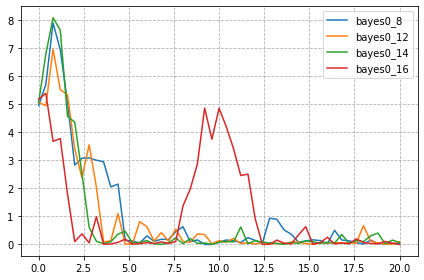

In [7]:
B0 = np.loadtxt("BAYES.0.J")

for i in [7,11,13,15]:
    plt.plot(B0[:,0], B0[:,i], label = "bayes0_"+str(i+1) )
plt.legend()
plt.grid(linestyle="--")
plt.tight_layout()